In [61]:
import pandas as pd
import numpy as np
import numpy_financial as npf
from pandas_datareader import data as wb
import datetime
import requests
from scipy.stats.mstats import gmean
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [62]:
start_time = datetime.datetime.now() # Замер времени выполнения скрипта для одного тикера

In [63]:
COMPANY = 'MSFT'
KEY = '2105b9f242d47b69fc73f0f2205be048'

In [64]:
IS = requests.get(f'https://financialmodelingprep.com/api/v3/income-statement/{COMPANY}?apikey={KEY}').json()
FIS = requests.get(f'https://financialmodelingprep.com/api/v3/financials/income-statement/{COMPANY}?apikey={KEY}').json()
BL = requests.get(f'https://financialmodelingprep.com/api/v3/balance-sheet-statement/{COMPANY}?apikey={KEY}').json()
RT = requests.get(f'https://financialmodelingprep.com/api/v3/ratios/{COMPANY}?apikey={KEY}').json()
CF = requests.get(f'https://financialmodelingprep.com/api/v3/cash-flow-statement/{COMPANY}?apikey={KEY}').json()
EV = requests.get(f'https://financialmodelingprep.com/api/v3/enterprise-values/{COMPANY}?apikey={KEY}').json()
PF = requests.get(f'https://financialmodelingprep.com/api/v3/profile/{COMPANY}?apikey={KEY}').json()
CQ = requests.get(f'https://financialmodelingprep.com/api/v3/quote/{COMPANY}?apikey={KEY}').json()
FS = requests.get(f'https://financialmodelingprep.com/api/v3/financial-statement-full-as-reported/{COMPANY}?apikey={KEY}').json()
KM = requests.get(f'https://financialmodelingprep.com/api/v3/key-metrics/{COMPANY}?apikey={KEY}').json()

In [65]:
    financial_income_statement = pd.DataFrame(FIS['financials'])
    income_statement = pd.DataFrame(IS)
    balance = pd.DataFrame(BL)
    ratios = pd.DataFrame(RT)
    cash_flow = pd.DataFrame(CF)
    enterprise_value = pd.DataFrame(EV)
    company_profile = pd.DataFrame(PF)
    real_time_quote = pd.DataFrame(CQ)
    financial_statement = pd.DataFrame(FS)
    key_metrics = pd.DataFrame(KM)

In [66]:
LTGrowth = 0.02
LTdis = 0.08
PRICE = real_time_quote['price'][0]
company_profile_beta = company_profile['beta']
Total_rating = []

In [67]:
work_table = pd.concat(
        (income_statement[['date', 'revenue', 'operatingIncome', 'netIncome', 'eps', 'ebitda',
                          'depreciationAndAmortization', 'interestExpense', 'incomeBeforeTax',
                               'incomeTaxExpense']].replace(np.nan, 0)[0:10],
        balance[['totalAssets', 'totalLiabilities', 'totalStockholdersEquity',
                        'totalDebt', 'netDebt']].replace(np.nan, 0)[0:10],
        ratios[['dividendPayoutRatio', 'dividendYield', 'effectiveTaxRate', 'payoutRatio']].replace(
            np.nan, 0)[0:10],
        cash_flow[['freeCashFlow', 'dividendsPaid']].replace(np.nan, 0)[0:10],
        enterprise_value[['numberOfShares', 'stockPrice']].replace(np.nan, 0)[0:10],
        key_metrics[['debtToEquity', 'bookValuePerShare', 'roe', 'currentRatio']].replace(np.nan,
                                                                                          0)[0:10],
        financial_income_statement['Dividend per Share'].replace(np.nan, 0)[0:10],
        company_profile['mktCap'].replace(np.nan, 0)[0:10]

        ),axis=1)

In [68]:
print(work_table)

         date       revenue  operatingIncome     netIncome      eps  \
0  2020-06-30  143015000000      52826000000  4.428100e+10  5.79817   
1  2019-06-30  125843000000      42933000000  3.924000e+10  5.08454   
2  2018-06-30  110360000000      35011000000  1.657100e+10  3.88889   
3  2017-06-30   96571000000      28970000000  2.548900e+10  3.61560   
4  2016-06-30   91154000000      25756000000  2.053900e+10  2.70637   
5  2015-06-30   93580000000      17978000000  1.219300e+10  2.29091   
6  2014-06-30   86833000000      27653000000  2.207400e+10  2.65000   
7  2013-06-30   77849000000      26556000000  2.186300e+10  2.60000   
8  2012-06-30   73723000000      21763000000  1.697800e+10  2.55000   
9  2011-06-30   69943000000      27161000000  2.315000e+10  2.69000   

        ebitda  depreciationAndAmortization  interestExpense  incomeBeforeTax  \
0  68423000000                 1.279600e+10     2.591000e+09      53036000000   
1  58056000000                 1.168200e+10     2.686000

Расчет показателей качества

In [69]:
# считаем рост выручки______________________________________________________________
revenue_growth = round((((work_table['revenue'][0]/work_table['revenue'][9]) ** 0.1) -1), 2)

print(f'revenue_growth {revenue_growth}')


if revenue_growth > 0.06:
    revenue_growth_rating = 1
elif 0.05 > revenue_growth > 0.02:
    revenue_growth_rating = 0
else:
    revenue_growth_rating = -1

Total_rating.append(revenue_growth_rating)

# считаем Использование прибыли______________________________________________________________
average_dividend_payout_percentage = np.mean(work_table['dividendYield'][0:])

# average_percentage_of_buyback  # не найден   !!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

SHAREHOLDERS_EQUITY = (work_table['totalAssets'] - work_table['totalLiabilities'])

average_quity_SHAREHOLDERS_EQUITY = round((((SHAREHOLDERS_EQUITY[0] / SHAREHOLDERS_EQUITY[9]) ** 0.1) -1), 2)

use_of_profit = round((average_dividend_payout_percentage + average_quity_SHAREHOLDERS_EQUITY), 2)

print(f'use_of_profit {use_of_profit}')

if use_of_profit < 0.06:
    use_of_profit_rating = -2
elif 0.1 < use_of_profit > 0.06:
    use_of_profit_rating = 0
else:
    use_of_profit_rating = 2

Total_rating.append(use_of_profit_rating)

# Считаем Операционную маржу_________________________________________________________________

OPERATING_MAR = work_table['operatingIncome']/work_table['revenue']

operating_margin = round(np.mean(OPERATING_MAR[0:]), 2)

print(f'operating_margin {operating_margin}')

if operating_margin < 0.06:
    operating_margin_rating = -2
elif 0.14 > operating_margin > 0.06:
    operating_margin_rating = 0
else:
    operating_margin_rating = 2

Total_rating.append(operating_margin_rating)

# Считаем Динамику операционной маржи_________________________________________________________________

if OPERATING_MAR.std() < 0.1:
    operating_margin_dynamics = 'Рост'
    operating_margin_dynamics_rating = 2
else:
    operating_margin_dynamics = 'Падение'
    operating_margin_dynamics_rating = -2

Total_rating.append(operating_margin_dynamics_rating)

print(f'operating_margin_dynamics {operating_margin_dynamics}')

# Считаем Маржу чистой прибыли_________________________________________________________________

NET_PROFIT_MAR = work_table['netIncome']/work_table['revenue']

net_profit_margin = round(np.mean(NET_PROFIT_MAR[0:]), 2)

print(f'net_profit_margin {net_profit_margin}')

if net_profit_margin < 0.06:
    net_profit_margin_rating = -2
elif 0.1 > net_profit_margin > 0.06:
    net_profit_margin_rating = 0
else:
    net_profit_margin_rating = 2

Total_rating.append(net_profit_margin_rating)

# Считаем Динамику маржи чистой прибыли_________________________________________________________________

if NET_PROFIT_MAR.std() < 0.1 :
    net_profit_margin_dynamics = 'Рост'
    net_profit_margin_dynamics_rating = 1
else:
    net_profit_margin_dynamics = 'Падение'
    net_profit_margin_dynamics_rating = -1

Total_rating.append(net_profit_margin_dynamics_rating)

print(f'net_profit_margin_dynamics {net_profit_margin_dynamics}')

# Считаем Рост EPS_________________________________________________________________

EPS_growth = round((((work_table['eps'][0]/work_table['eps'][9]) ** 0.1) -1), 2)   # Первый вариант, eps - берем из API

# EPS_growth = round((((SHAREHOLDERS_EQUITY[0] / SHAREHOLDERS_EQUITY[9]) ** 0.1) -1), 2)  # Второй вариант, eps = totalAssets - totalLiabilities

#  !!!!!!!!!!!!!!!!!При разных вариантах разные значения!!!!!!!!!!!!!!!!!!!!!!

print(f'EPS_growth {EPS_growth}')

if EPS_growth < 0.06:
    EPS_growth_rating = -2
elif 0.1 > EPS_growth > 0.06:
    EPS_growth_rating = 0
else:
    EPS_growth_rating = 2

Total_rating.append(EPS_growth_rating)

# Считаем Уровень долга_________________________________________________________________

debt_level = round(np.mean(work_table['totalLiabilities']/work_table['totalAssets']), 2)

print(f'debt_level {debt_level}')

if debt_level < 0.5:
    debt_level_rating = 1
elif 0.7 > debt_level > 0.5:
    debt_level_rating = 0
else:
    debt_level_rating = -1

Total_rating.append(debt_level_rating)

 # ___________________________________ ROE_DuPont _______________________________________________

Profitability = []
TechnicalEfficiency = []
FinancialStructure = []

for year in range(0, 10):
    last_year = year + 1
    Profitability.append(work_table['netIncome'][year] / work_table['revenue'][year])
    TechnicalEfficiency.append(work_table['revenue'][year] / (
            (work_table['totalAssets'][year] + balance['totalAssets'].replace(np.nan, 0)[last_year]) / 2))
    FinancialStructure.append(((work_table['totalAssets'][year] + balance['totalAssets'].replace(np.nan, 0)[last_year]) / 2) /
                                      ((work_table['totalStockholdersEquity'][year] +
                                        balance['totalStockholdersEquity'].replace(np.nan, 0)[last_year]) / 2))

work_table['Profitability'] = Profitability
work_table['TechnicalEfficiency'] = TechnicalEfficiency
work_table['FinancialStructure'] = FinancialStructure

work_table['ROE_DuPont'] = work_table['FinancialStructure'] * work_table['TechnicalEfficiency'] * \
                                   work_table['Profitability']

ROE_DuPont = round(work_table['ROE_DuPont'].mean(axis=0), 5)
decomp = work_table[['date', 'Profitability', 'TechnicalEfficiency', 'FinancialStructure', 'ROE_DuPont']]

print(f'ROE_DuPont_average {ROE_DuPont}')
print(decomp)

if ROE_DuPont < 0.08:
    ROE_average_rating = -2
elif 0.14 > ROE_DuPont > 0.08:
    ROE_average_rating = 0
else:
    ROE_average_rating = 2

Total_rating.append(ROE_average_rating)

# Считаем ROA_________________________________________________________________

ROA_average = round(np.mean(work_table['netIncome']/work_table['totalAssets']), 2)

print(f'ROA_average {ROA_average}')

if ROA_average < 0.06:
    ROA_average_rating = -1
elif 0.08 > ROA_average > 0.06:
    ROA_average_rating = 0
else:
    ROA_average_rating = 1

Total_rating.append(ROA_average_rating)

# Получаем общую оценку_________________________________________________________________

print(Total_rating)
print(f'Общая оценка = {sum(Total_rating)}')

revenue_growth 0.07
use_of_profit 0.1
operating_margin 0.31
operating_margin_dynamics Рост
net_profit_margin 0.25
net_profit_margin_dynamics Рост
EPS_growth 0.08
debt_level 0.56
ROE_DuPont_average 0.30389
         date  Profitability  TechnicalEfficiency  FinancialStructure  \
0  2020-06-30       0.309625             0.486556            2.664444   
1  2019-06-30       0.311817             0.461467            2.947365   
2  2018-06-30       0.150154             0.433498            2.987520   
3  2017-06-30       0.263941             0.435220            2.778696   
4  2016-06-30       0.225322             0.495483            2.419385   
5  2015-06-30       0.130295             0.539590            2.041927   
6  2014-06-30       0.254212             0.551645            1.865814   
7  2013-06-30       0.280839             0.590432            1.814792   
8  2012-06-30       0.230294             0.641139            1.862960   
9  2011-06-30       0.330984             0.718038            1.88

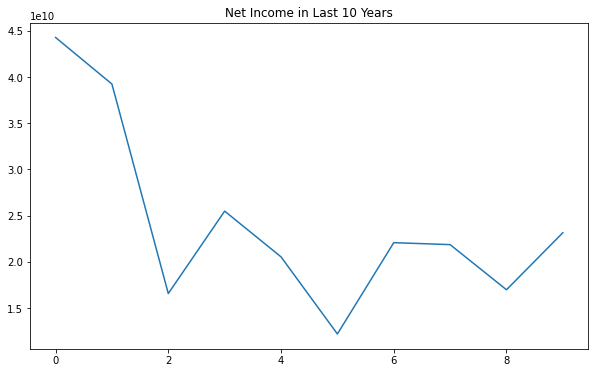

In [70]:
work_table['netIncome'].plot(figsize=(10,6), title="Net Income in Last 10 Years")

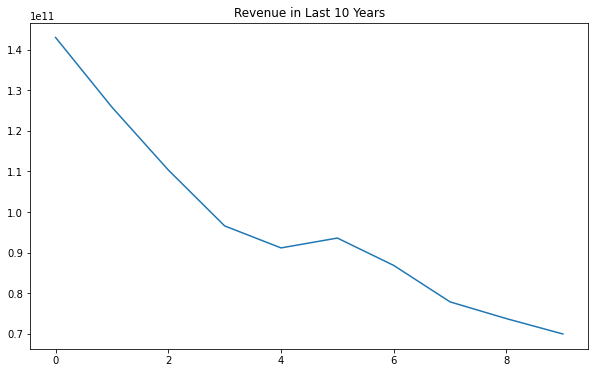

In [71]:
work_table['revenue'].plot(figsize=(10,6), title="Revenue in Last 10 Years")

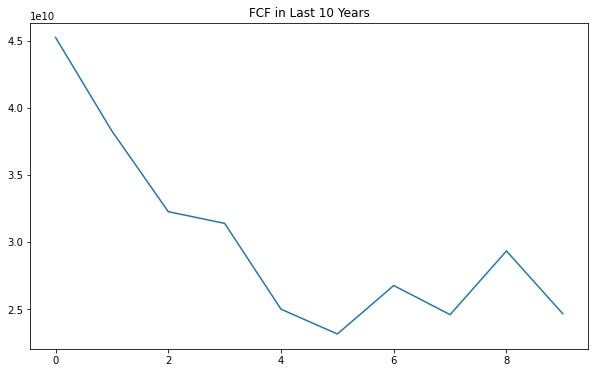

In [72]:
work_table['freeCashFlow'].plot(figsize=(10,6), title="FCF in Last 10 Years")

# Оцениваем инвестиционную стоимость  

In [73]:
print('Считаем инвестиционную стоимость по дивидендной модели Гордона')

Dtoday =   work_table['dividendsPaid'][0] / work_table['numberOfShares'][0]

# ROE and PAyout Ratio

ROE_formul = ROE_DuPont
print(f'ROE_formul {ROE_formul}')

payout_ratio = work_table['payoutRatio'].median(axis = 0)
sustgrwothrate = ROE_formul * (1 - payout_ratio)
print(f'payout_ratio {payout_ratio}')
print(f'sustgrwothrate {sustgrwothrate}')

##Cost of equity:
# Risk Free Rate
start = datetime.datetime(2019, 2, 1)
end= datetime.datetime.today().strftime('%Y-%m-%d')
#end = datetime.datetime(2020, 2, 27)

Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
RF = float(Treasury.iloc[-1])
RF = RF / 100
print(f'RF {RF}')

# Beta
beta = float(company_profile_beta)
print(f'beta {beta}')

# Market Return
# Считаем годовую доходность
data = wb.DataReader('^GSPC', data_source='yahoo', start='2001-1-1') # нужно определиться с переменной
data['simple_return'] = (data['Adj Close'] / data['Adj Close'].shift(1)) - 1
data['simple_return'].replace(np.nan, 0)
avg_returns_a = data['simple_return'].mean() * 250

print(f'Годовая доходность S&P500 {avg_returns_a*100}')

# Drop all Not a number values using drop method.
ke = RF + (beta * (avg_returns_a - RF))
print(f'Стоимость капитала {ke*100}')

DDM = (Dtoday * (1 + sustgrwothrate)) / (ke - sustgrwothrate)

print(f'Расчетная стоимость по модели Гордона {DDM}')

valuecompany(COMPANY)

print(f'Время выполнения :{datetime.datetime.now() - start_time}') # Замер времени

Считаем инвестиционную стоимость по дивидендной модели Гордона
ROE_formul 0.30389
payout_ratio 0.3891564237291216
sustgrwothrate 0.18562925439295722
RF 0.0069
beta 0.88189
Годовая доходность S&P500 6.989954239098226
Стоимость капитала 6.245866643918334
Расчетная стоимость по модели Гордона 18.964913658106845
ROE_formul 0.30389
payout_ratio 0.3891564237291216
sustgrwothrate 0.18562925439295722
RF 0.0069
beta 0.88189
Годовая доходность S&P500 6.989954239098226
Стоимость капитала 6.245866643918334
Расчетная стоимость по модели Гордона 18.964913658106845
Время выполнения :0:00:09.216450


# Расчет методом дисконтирования FCF спрогнозируемого методом линейной регрессии

In [75]:
# 'year_index' as the order of the year
work_table['year_index'] = range(1, len(work_table) + 1)[::-1]
# add intercept
work_table['intercept'] = 1

print(work_table)


# modeling
freeCashFlow_model = sm.OLS(work_table['freeCashFlow'], work_table[['year_index','intercept']]).fit()


freeCashFlow_pred_lr = freeCashFlow_model.predict([19,1])[0] #Прогнозируем через 10 лет


freeCashFlow_pred_lr5 = freeCashFlow_model.predict([14,1])[0] #Прогнозируем через 5 лет
freeCashFlow_pred_lr4 = freeCashFlow_model.predict([13,1])[0]
freeCashFlow_pred_lr3 = freeCashFlow_model.predict([12,1])[0]
freeCashFlow_pred_lr2 = freeCashFlow_model.predict([11,1])[0]
freeCashFlow_pred_lr1 = freeCashFlow_model.predict([10,1])[0]


# CAGR FCF

CF_forecast = {}

CF_forecast['next_year1'] = {}
CF_forecast['next_year1']['freeCashFlow'] = freeCashFlow_pred_lr1

CF_forecast['next_year2'] = {}
CF_forecast['next_year2']['freeCashFlow'] = freeCashFlow_pred_lr2

CF_forecast['next_year3'] = {}
CF_forecast['next_year3']['freeCashFlow'] = freeCashFlow_pred_lr3

CF_forecast['next_year4'] = {}
CF_forecast['next_year4']['freeCashFlow'] = freeCashFlow_pred_lr4

CF_forecast['next_year5'] = {}
CF_forecast['next_year5']['freeCashFlow'] = freeCashFlow_pred_lr5

print(CF_forecast)

print(f'freeCashFlow_pred_lr1 = {freeCashFlow_pred_lr1}')
print(f'freeCashFlow_pred_lr2 = {freeCashFlow_pred_lr2}')
print(f'freeCashFlow_pred_lr3 = {freeCashFlow_pred_lr3}')
print(f'freeCashFlow_pred_lr4 = {freeCashFlow_pred_lr4}')
print(f'freeCashFlow_pred_lr5 = {freeCashFlow_pred_lr5}')



print(freeCashFlow_pred_lr)


# ________________________________________  Расчет WACC  _______________________________________________


WACC = (work_table['mktCap'][0] / (work_table['mktCap'][0] + work_table['netDebt'][0:2].mean())) * ke + (
                work_table['netDebt'][0:2].mean() / (work_table['mktCap'][0] + work_table['netDebt'][0:2].mean())) * (
                        work_table['interestExpense'][0] / work_table['netDebt'][0:2].mean()) \
               * (1 - (work_table['incomeTaxExpense'][0] / work_table['incomeBeforeTax'][0]))

print(f'WACC {WACC}')
print(f'''mktCap {work_table['mktCap'][0]}''')
print(f'''netDebt {work_table['netDebt'][0:2].mean()}''')
print(f'''interestExpense {work_table['interestExpense'][0]}''')
print(f'''incomeTaxExpense {work_table['incomeTaxExpense'][0]}''')
print(f'''incomeBeforeTax {work_table['incomeBeforeTax'][0]}''')

wacc_company = WACC

print('wacc of = ' + COMPANY + ' is \n' + str((wacc_company * 100)) + '%')

CF_forec = pd.DataFrame.from_dict(CF_forecast, orient='columns')

FCF_List = CF_forec.iloc[0:].values.tolist()

npv = npf.npv(wacc_company, FCF_List[0])
print(f'npv = {npv}')

Terminal_value_Discounted = freeCashFlow_pred_lr * (1 + LTGrowth) / (LTdis - LTGrowth)

print(f'Terminal_value_Discounted = {Terminal_value_Discounted}')

sum_num = npv + Terminal_value_Discounted
print(f'sum_num = {sum_num}')

spl_num = sum_num / work_table['numberOfShares'][0]
print(f'Estimated price = {spl_num}')

difference_model_and_market_value = spl_num - PRICE
print(f'stock price = {PRICE}')

print(f'difference_model_and_market_value = {difference_model_and_market_value}')

         date       revenue  operatingIncome     netIncome      eps  \
0  2020-06-30  143015000000      52826000000  4.428100e+10  5.79817   
1  2019-06-30  125843000000      42933000000  3.924000e+10  5.08454   
2  2018-06-30  110360000000      35011000000  1.657100e+10  3.88889   
3  2017-06-30   96571000000      28970000000  2.548900e+10  3.61560   
4  2016-06-30   91154000000      25756000000  2.053900e+10  2.70637   
5  2015-06-30   93580000000      17978000000  1.219300e+10  2.29091   
6  2014-06-30   86833000000      27653000000  2.207400e+10  2.65000   
7  2013-06-30   77849000000      26556000000  2.186300e+10  2.60000   
8  2012-06-30   73723000000      21763000000  1.697800e+10  2.55000   
9  2011-06-30   69943000000      27161000000  2.315000e+10  2.69000   

        ebitda  depreciationAndAmortization  interestExpense  incomeBeforeTax  \
0  68423000000                 1.279600e+10     2.591000e+09      53036000000   
1  58056000000                 1.168200e+10     2.686000

# Стоимость акции по дивам и балансовой стоимости(линейная регрессия)

In [ ]:
dvd_avg = np.mean((work_table['Dividend per Share']).astype(float))  # Определим средний дивиденд
print(dvd_avg)


In [ ]:
start = datetime.datetime(1999, 12, 31)
end= datetime.datetime.today().strftime('%Y-%m-%d')
Treasury = wb.DataReader(['DGS10'], 'fred', start, end)
RF = float(Treasury.iloc[-1])
risk_free_rate = RF/100
# The discounted capital for the dividend of 3-year later
dvd_avg / (1 + risk_free_rate) ** 3
# The discounted capital for the dividend of 10-year later
# dvd_avg/(1+risk_free_rate)**10

In [ ]:
dvd_total = 0
for j in range(1, 11):
    dvd_total = dvd_total + dvd_avg / (1 + risk_free_rate) ** j
print(dvd_total)

In [ ]:
growth_rate_of_10y = (work_table['bookValuePerShare'][0]) / (work_table['bookValuePerShare'][9])
avg_growth_rate = growth_rate_of_10y ** (1 / 10)
print(avg_growth_rate)

In [ ]:
bvps_pred = (work_table['bookValuePerShare'][0]) * (avg_growth_rate ** 10)
print(bvps_pred)

In [ ]:
data_intrinsic = bvps_pred + dvd_total
print(data_intrinsic)

In [ ]:
work_table['bookValuePerShare'].plot(figsize=(10,6), title="Book Value in Last 10 Years")

In [ ]:
work_table['Dividend per Share'].astype('float').plot(figsize=(10,6), title="Dividend per Share in Last 10 Years")

In [ ]:
# 'year_index' as the order of the year
work_table['year_index'] = range(1, len(work_table) + 1)[::-1]
# add intercept
work_table['intercept'] = 1

In [ ]:
# modeling
bvps_model = sm.OLS(work_table['bookValuePerShare'], work_table[['year_index', 'intercept']]).fit()

In [ ]:
bvps_pred_lr = bvps_model.predict([19, 1])[0]  # Прогнозируем балансовую стоимость через 10 лет
print(f'bvps_pred_lr через 10 лет: {bvps_pred_lr}' )

In [ ]:
dvd_model = sm.OLS((work_table['Dividend per Share']).astype(float), work_table[['year_index', 'intercept']]).fit()

dvd_model.predict([19, 1])[0]  # Определить дивиденд через 10 лет

In [ ]:
# Дивиденды за 10 лет
dvd_total_lr = 0
current_year_order = 9
for j in range(1, 11):
    dvd_new = dvd_model.predict([current_year_order + j, 1])[0]
    dvd_total_lr = dvd_total_lr + dvd_new / (1 + risk_free_rate) ** j
print(f'dvd_total_lr: {dvd_total_lr}' )

In [ ]:
aapl_intrinsic_lr = dvd_total_lr + bvps_pred_lr
print(f'aapl_intrinsic_lr: {aapl_intrinsic_lr}' )

In [ ]:
difference_model_and_market_value = aapl_intrinsic_lr - PRICE
print(f'stock price = {PRICE}')
print(f'difference_model_and_market_value = {difference_model_and_market_value}')

# Оценка дисперсии модели линейной регресси дивов через R-Squared

In [ ]:
# # creating OLS regression

print(work_table['Dividend per Share'])

r2_table = pd.DataFrame()
r2_table['y'] = work_table['Dividend per Share'][0:10].replace(np.nan, 0).replace('', 0, regex=True).astype(float)
r2_table['x'] = work_table['year_index']

print(r2_table)


slope, intercept, r_value, p_value, std_err = stats.linregress(r2_table['x'], r2_table['y'])
def linefitline(b):
    return intercept + slope * b

# line1 = linefitline(r2_table['x'])
line1 = linefitline(r2_table['x'])


#plot line
plt.scatter(r2_table['x'], r2_table['y'])
plt.plot(r2_table['x'], line1, c='g')
plt.show()


line2 = np.full(10, [r2_table['y'].mean()])
plt.scatter(r2_table['x'], r2_table['y'])
plt.plot(r2_table['x'], line2, c='r')
plt.show()

differences_line1 = linefitline(r2_table['x']) - r2_table['y']
line1sum = 0
for k in differences_line1:
    line1sum = line1sum + (k * k)

differences_line2 = line2 - r2_table['y']
line2sum = 0
for k in differences_line2:
    line2sum = line2sum + (k * k)

print(line2sum)

r2 = r2_score(r2_table['y'], linefitline(r2_table['x']))
print('The rsquared value is: ' + str(r2))

# Оценка дисперсии модели линейной регресси FCF через R-Squared

In [ ]:
# # creating OLS regression


r2_table_FCF = pd.DataFrame()
r2_table_FCF['y'] = work_table['freeCashFlow'].replace(np.nan, 0).replace('', 0, regex=True)
r2_table_FCF['x'] = work_table['year_index']

print(r2_table_FCF)

slope, intercept, r_value, p_value, std_err = stats.linregress(r2_table_FCF['x'], r2_table_FCF['y'])


def linefitline(b):
    return intercept + slope * b


# line1 = linefitline(r2_table['x'])
line1 = linefitline(r2_table_FCF['x'])

# plot line
plt.scatter(r2_table_FCF['x'], r2_table_FCF['y'])
plt.plot(r2_table_FCF['x'], line1, c='g')
plt.show()

line2 = np.full(10, [r2_table_FCF['y'].mean()])
plt.scatter(r2_table_FCF['x'], r2_table_FCF['y'])
plt.plot(r2_table_FCF['x'], line2, c='r')
plt.show()

differences_line1 = linefitline(r2_table_FCF['x']) - r2_table_FCF['y']
line1sum = 0
for k in differences_line1:
    line1sum = line1sum + (k * k)

differences_line2 = line2 - r2_table_FCF['y']
line2sum = 0
for k in differences_line2:
    line2sum = line2sum + (k * k)

print(line2sum)

r2_FCF = r2_score(r2_table_FCF['y'], linefitline(r2_table_FCF['x']))
print('The rsquared value is: ' + str(r2_FCF))